In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [5]:
from sklearn.model_selection import train_test_split
# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# SVC without under sampling , with 20 features

Fitting 10 folds for each of 50 candidates, totalling 500 fits
✅ Best Params: {'svc__C': 1.0, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.91      0.80      0.85        96
        ADHD       0.55      0.74      0.63        31

    accuracy                           0.79       127
   macro avg       0.73      0.77      0.74       127
weighted avg       0.82      0.79      0.80       127

ROC AUC (Train): 0.8649193548387097


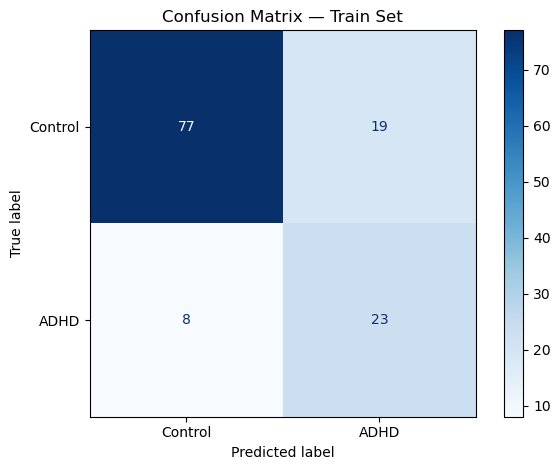

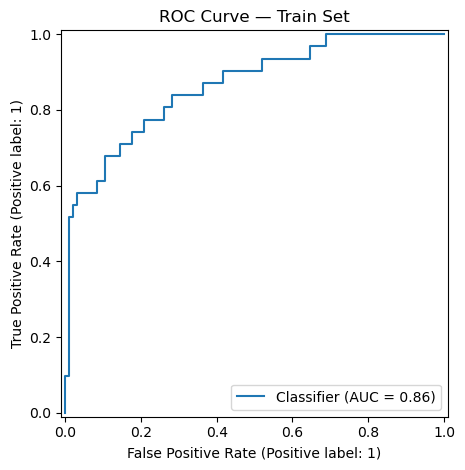

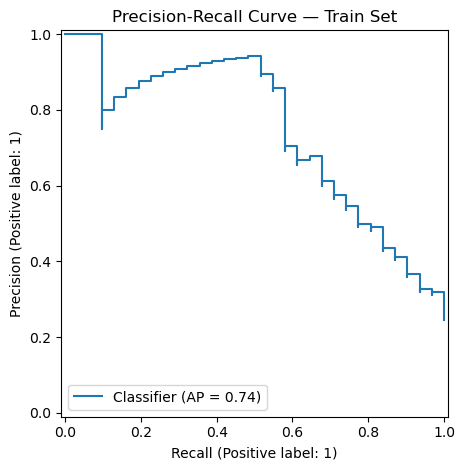


📊 Cross-Validated Scores:
fit_time: 0.2358
score_time: 0.0388
test_accuracy: 0.6038
train_accuracy: 0.7743
test_precision_macro: 0.5483
train_precision_macro: 0.7314
test_recall_macro: 0.5667
train_recall_macro: 0.7976
test_f1_macro: 0.5278
train_f1_macro: 0.7404
test_roc_auc: 0.6910
train_roc_auc: 0.8784

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.86      0.75      0.80        24
        ADHD       0.45      0.62      0.53         8

    accuracy                           0.72        32
   macro avg       0.66      0.69      0.66        32
weighted avg       0.76      0.72      0.73        32

ROC AUC (Test): 0.8177083333333334


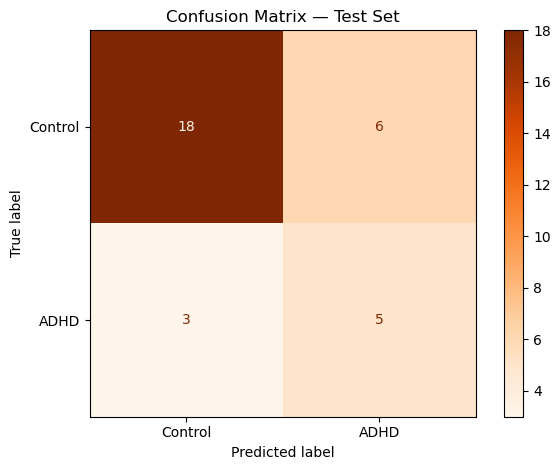

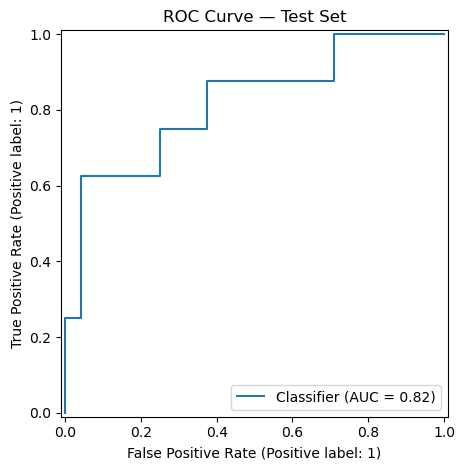

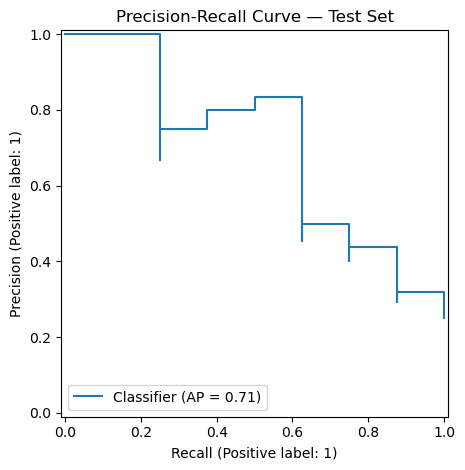

In [6]:

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

# === SVC Model (RBF Kernel) ===
svc_model = SVC(kernel='rbf', probability=True)

# === Pipeline: Raw -> RF selector -> Scaler -> SVC ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('svc', svc_model)
])

# === Param Grid for SVC ===
param_grid = {
    'svc__C': np.logspace(-2, 2, 5),
    'svc__gamma': np.logspace(-3, 1, 5),
    'svc__class_weight': [None, 'balanced']
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# Bagging clf using svc

Fitting 10 folds for each of 12 candidates, totalling 120 fits


e:\anaconda\envs\basic\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best Params: {'lr__estimator__C': 0.001, 'lr__estimator__gamma': 'scale'}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.84      1.00      0.91        96
        ADHD       1.00      0.42      0.59        31

    accuracy                           0.86       127
   macro avg       0.92      0.71      0.75       127
weighted avg       0.88      0.86      0.84       127

ROC AUC (Train): 0.9838709677419355


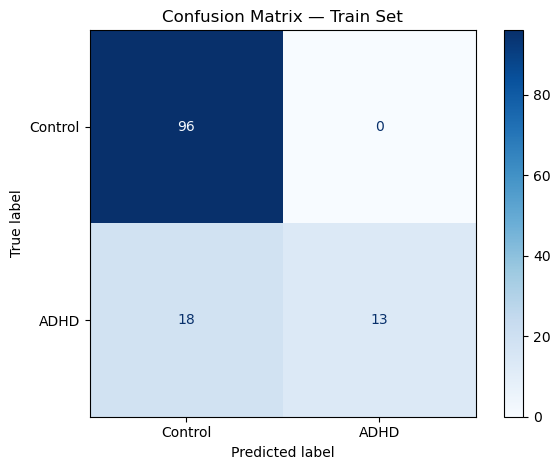

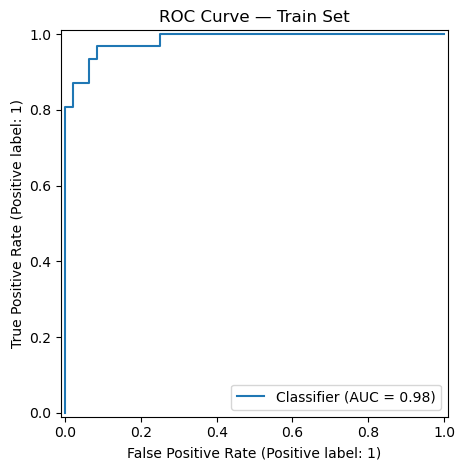

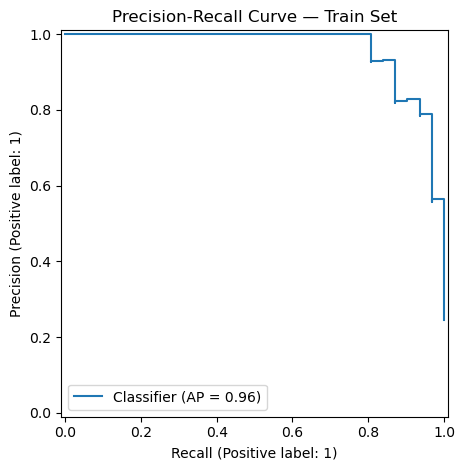

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklea


📊 Cross-Validated Scores:
fit_time: 2.2597
score_time: 1.1086
test_accuracy: 0.7550
train_accuracy: 0.8379
test_precision_macro: 0.3775
train_precision_macro: 0.9120
test_recall_macro: 0.5000
train_recall_macro: 0.6696
test_f1_macro: 0.4302
train_f1_macro: 0.6988
test_roc_auc: 0.6812
train_roc_auc: 0.9716

📘 Classification Report (Test):


e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Control       0.75      1.00      0.86        24
        ADHD       0.00      0.00      0.00         8

    accuracy                           0.75        32
   macro avg       0.38      0.50      0.43        32
weighted avg       0.56      0.75      0.64        32

ROC AUC (Test): 0.75


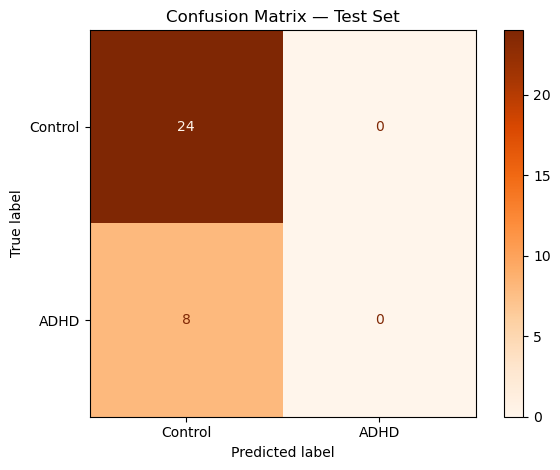

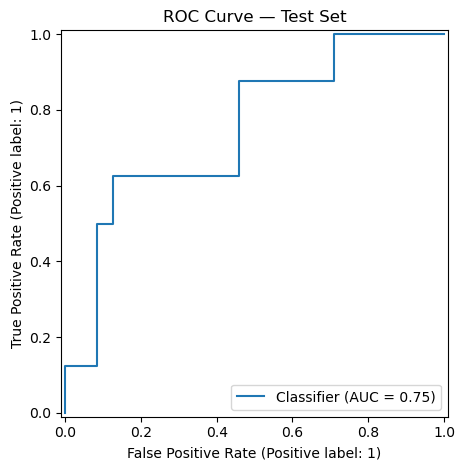

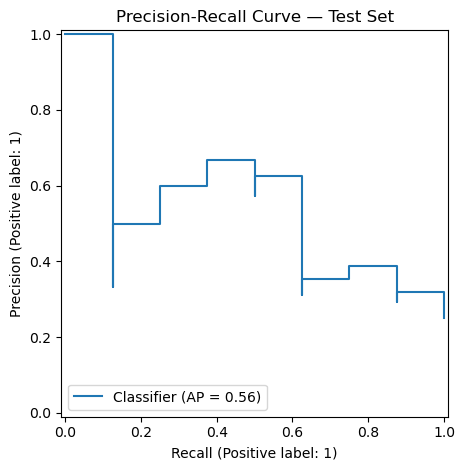

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.ensemble import BaggingClassifier 


from sklearn.model_selection import train_test_split

# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

svc_base_model = SVC(
    kernel='rbf',
    probability=True,  # Needed to use predict_proba
    class_weight=None,  # You can tune this
    random_state=42
)


# ✅ Wrap it in BaggingClassifier
svc_model = BaggingClassifier(
    estimator=svc_base_model,
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    bootstrap_features=False,
    max_samples=1.0,
    max_features=1.0
)


# === Pipeline: Raw -> RF selector -> Scaler -> LogisticRegression ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('lr', svc_model)
])

# === Param Grid ===
param_grid = {
    'lr__estimator__C': np.logspace(-3, 2, 6),  # from 0.001 to 100
    'lr__estimator__gamma': ['scale', 'auto']  # or floats like 0.01, 0.1 etc.
}



# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# SVC with RFECV

Fitting 5 folds for each of 25 candidates, totalling 125 fits


e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
119 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
118 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "e:\anaconda\envs\basic\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "e:\anaconda\envs\basic\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\utils\parallel.py", line 136, in __call__
    ret

✅ Best Params: {'svc__C': 0.01, 'svc__class_weight': 'balanced', 'svc__gamma': 0.001}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.00      0.00      0.00        96
        ADHD       0.24      1.00      0.39        31

    accuracy                           0.24       127
   macro avg       0.12      0.50      0.20       127
weighted avg       0.06      0.24      0.10       127

ROC AUC (Train): 0.18346774193548385


e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


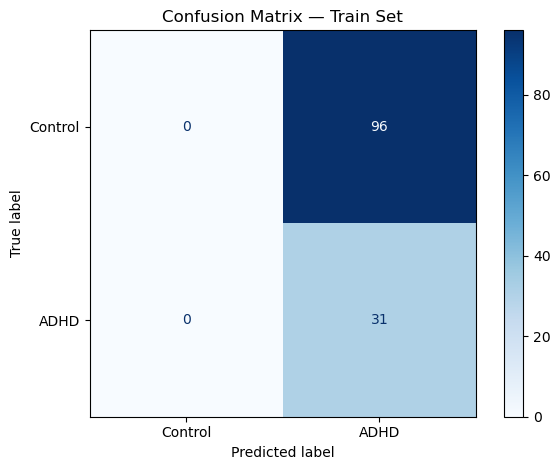

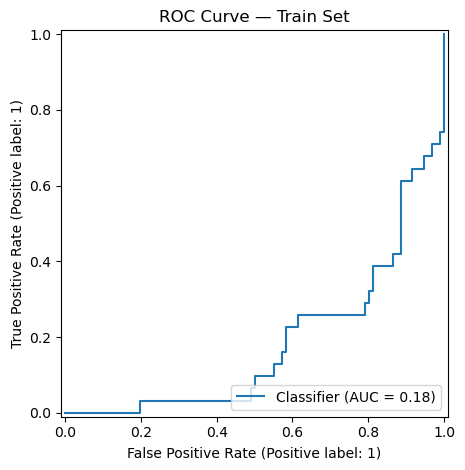

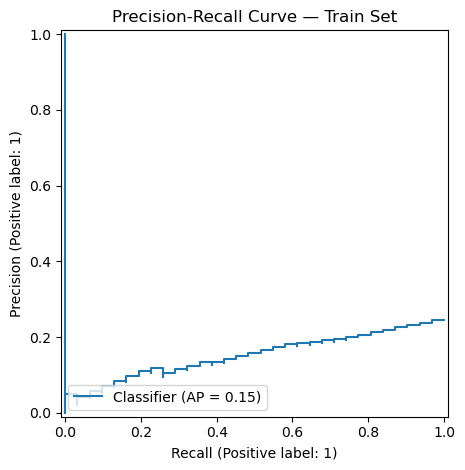

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklea


📊 Cross-Validated Scores:
fit_time: 12.4394
score_time: 0.0198
test_accuracy: 0.4440
train_accuracy: 0.4500
test_precision_macro: 0.2220
train_precision_macro: 0.2250
test_recall_macro: 0.5000
train_recall_macro: 0.5000
test_f1_macro: 0.2875
train_f1_macro: 0.2905
test_roc_auc: 0.5486
train_roc_auc: 0.8298

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.00      0.00      0.00        24
        ADHD       0.25      1.00      0.40         8

    accuracy                           0.25        32
   macro avg       0.12      0.50      0.20        32
weighted avg       0.06      0.25      0.10        32

ROC AUC (Test): 0.18229166666666666


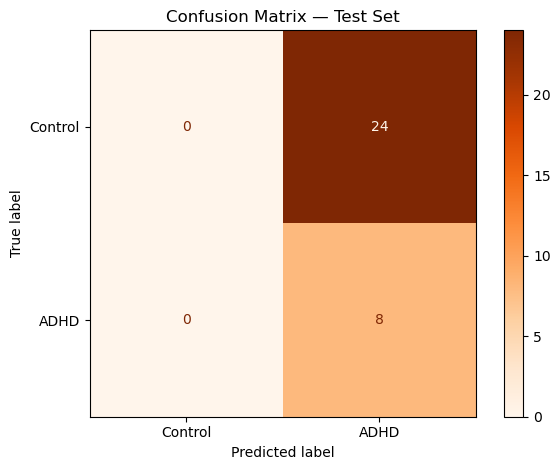

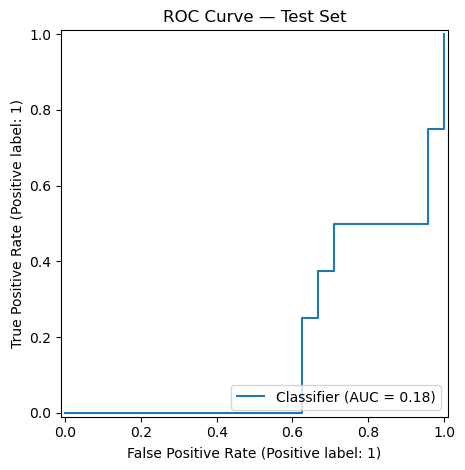

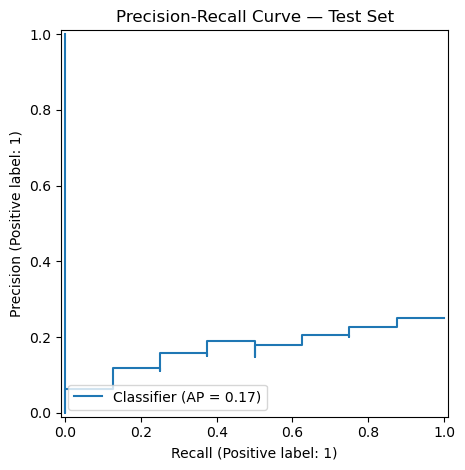

In [2]:

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.feature_selection import RFECV
# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
# === Feature Selector with Random Forest (on raw features) ===
rf_selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=60, random_state=42),
    step=1,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0,
    min_features_to_select=16
)

# === SVC Model (RBF Kernel) ===
svc_model = SVC(kernel='rbf', probability=True)

# === Pipeline: Raw -> RF selector -> Scaler -> SVC ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('svc', svc_model)
])

# === Param Grid for SVC ===
param_grid = {
    'svc__C': np.logspace(-2, 2, 5),
    'svc__gamma': np.logspace(-3, 1, 5),
    'svc__class_weight': ['balanced']
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X_train, y_train,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# SVC with under sample, with 4 or 20 features

Original class distribution:
Label
0    120
1     39
Name: count, dtype: int64
Downsampled class distribution:
Label
0    39
1    39
Name: count, dtype: int64
Fitting 10 folds for each of 50 candidates, totalling 500 fits
✅ Best Params: {'svc__C': 0.01, 'svc__class_weight': 'balanced', 'svc__gamma': 10.0}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        31
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62

ROC AUC (Train): 0.0


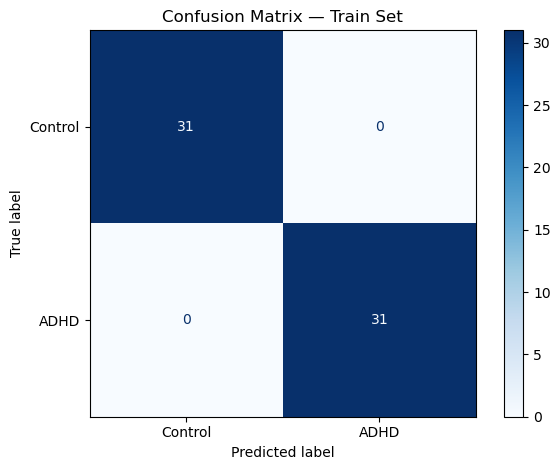

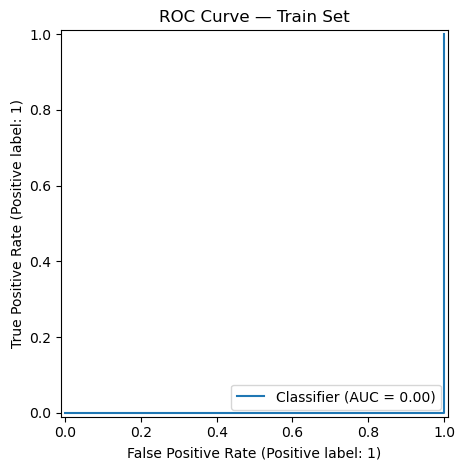

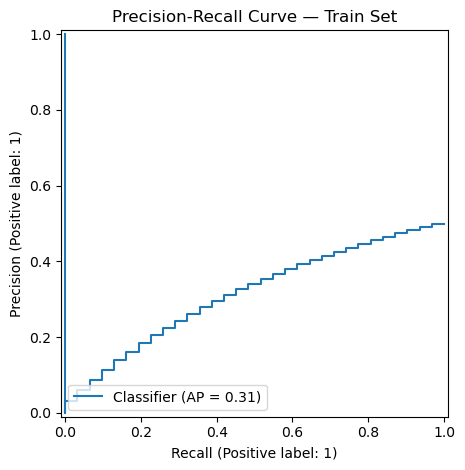

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classificati


📊 Cross-Validated Scores:
fit_time: 0.2135
score_time: 0.0449
test_accuracy: 0.5143
train_accuracy: 0.8982
test_precision: 0.3071
train_precision: 0.8491
test_recall: 0.4667
train_recall: 0.9000
test_f1: 0.3615
train_f1: 0.8659
test_roc_auc: 0.4611
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.58      0.88      0.70         8
        ADHD       0.75      0.38      0.50         8

    accuracy                           0.62        16
   macro avg       0.67      0.62      0.60        16
weighted avg       0.67      0.62      0.60        16

ROC AUC (Test): 0.296875


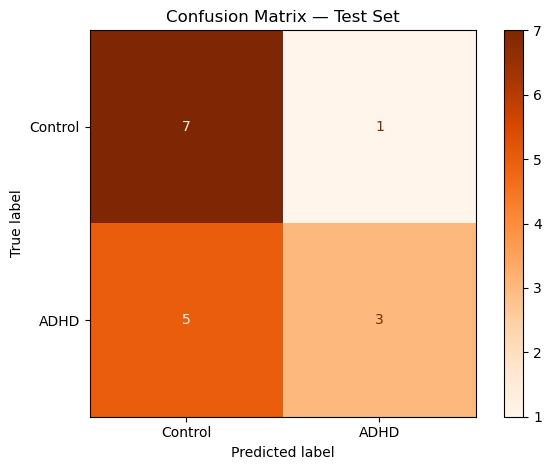

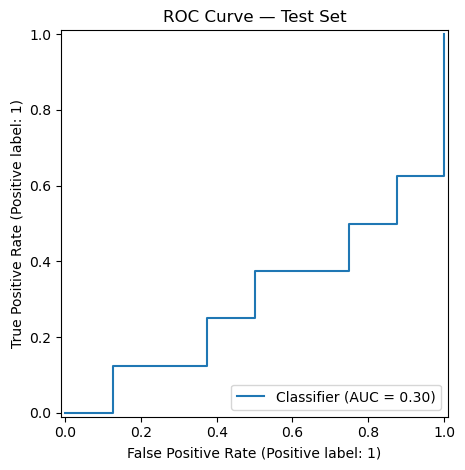

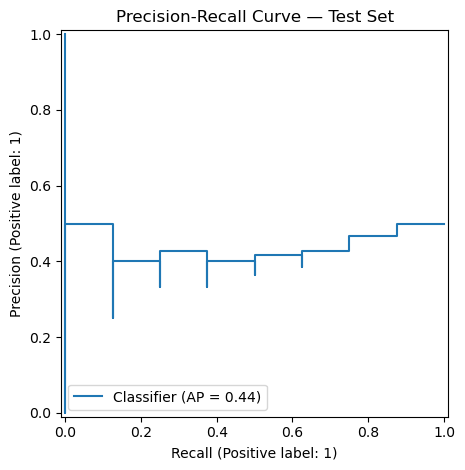

In [15]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Combined_4Condition_Cleaned.csv')

# Define target and features
target_col = 'Label'
X = df.drop(columns=['Subject_ID', target_col])
y = df[target_col]

# Check class counts
print("Original class distribution:")
print(y.value_counts())

# Downsample majority class (0) to match minority class (1)
df_majority = df[df[target_col] == 0]
df_minority = df[df[target_col] == 1]

n_minority = len(df_minority)
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=n_minority,
    random_state=42
)

df_downsampled = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

X_down = df_downsampled.drop(columns=['Subject_ID', target_col])
y_down = df_downsampled[target_col]

print("Downsampled class distribution:")
print(y_down.value_counts())

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_down, y_down, test_size=0.2, stratify=y_down, random_state=42
)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=4
)

# === SVC Model with RBF Kernel ===
svc_model = SVC(kernel='rbf', probability=True)

# === Pipeline: Feature Selection -> Scaler -> SVC ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('svc', svc_model)
])

# === Parameter Grid for SVC ===
param_grid = {
    'svc__C': np.logspace(-2, 2, 5),
    'svc__gamma': np.logspace(-3, 1, 5),
    'svc__class_weight': [None, 'balanced']
}

# === Grid Search with Cross-Validation ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X_train, y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# repeat undersampling for 10 times

In [13]:


# === Repeated Downsampling & Evaluation ===
n_repeats = 10
metrics = {'accuracy': [], 'f1_macro': [], 'roc_auc': []}

for i in range(n_repeats):
    print(f"🔁 Run {i + 1}/{n_repeats}")
    
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=n_minority,
        random_state=42 + i
    )
    df_downsampled = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42 + i).reset_index(drop=True)

    X_down = df_downsampled.drop(columns=['Subject_ID', target_col])
    y_down = df_downsampled[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X_down, y_down, test_size=0.2, stratify=y_down, random_state=42 + i
    )

    grid_p.fit(X_train, y_train)

    y_test_pred = grid_p.predict(X_test)
    y_test_proba = grid_p.predict_proba(X_test)[:, 1]

    metrics['accuracy'].append(accuracy_score(y_test, y_test_pred))
    metrics['f1_macro'].append(f1_score(y_test, y_test_pred, average='macro'))
    metrics['roc_auc'].append(roc_auc_score(y_test, y_test_proba))

# === Report Results ===
print("\n📊 Aggregated Metrics After 10 Repeats:")
for metric_name, scores in metrics.items():
    print(f"{metric_name}: Mean = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")


🔁 Run 1/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 2/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 3/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 4/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 5/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 6/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 7/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 8/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 9/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits
🔁 Run 10/10
Fitting 10 folds for each of 50 candidates, totalling 500 fits

📊 Aggregated Metrics After 10 Repeats:
accuracy: Mean = 0.5437, Std = 0.1154
f1_macro: Mean = 0.5271, Std = 0.1223
roc_auc: Mean = 0.5078, Std = 0.1127


# RandomUnderSampler

Fitting 50 folds for each of 25 candidates, totalling 1250 fits
✅ Best Params: {'svc__C': 0.01, 'svc__class_weight': None, 'svc__gamma': 10.0}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      0.70      0.82        96
        ADHD       0.52      1.00      0.68        31

    accuracy                           0.77       127
   macro avg       0.76      0.85      0.75       127
weighted avg       0.88      0.77      0.79       127

ROC AUC (Train): 0.0


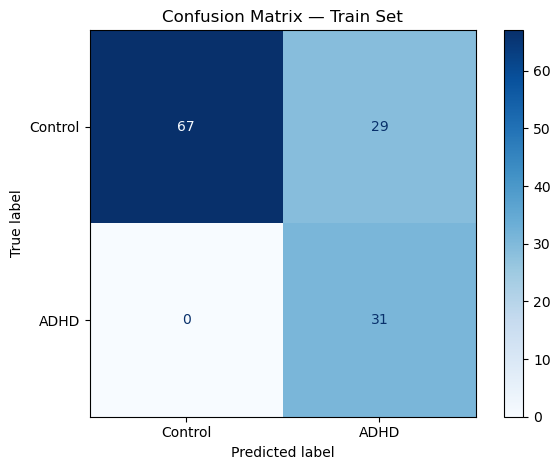

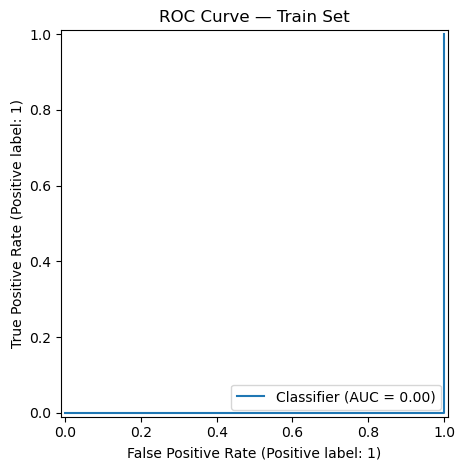

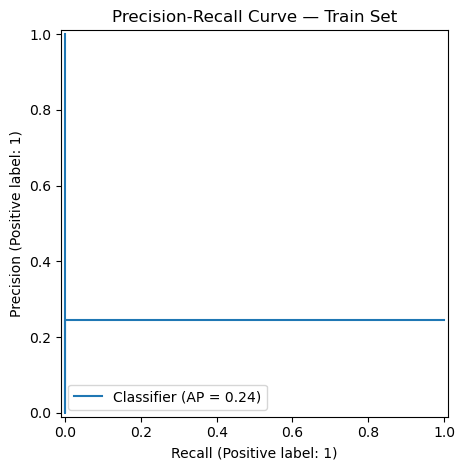


📊 Cross-Validated Scores:
fit_time: 0.2355
score_time: 0.0391
test_accuracy: 0.5685
train_accuracy: 0.8151
test_precision: 0.2993
train_precision: 0.5773
test_recall: 0.5254
train_recall: 1.0000
test_f1: 0.3731
train_f1: 0.7302
test_roc_auc: 0.5425
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.80      0.67      0.73        24
        ADHD       0.33      0.50      0.40         8

    accuracy                           0.62        32
   macro avg       0.57      0.58      0.56        32
weighted avg       0.68      0.62      0.65        32

ROC AUC (Test): 0.5


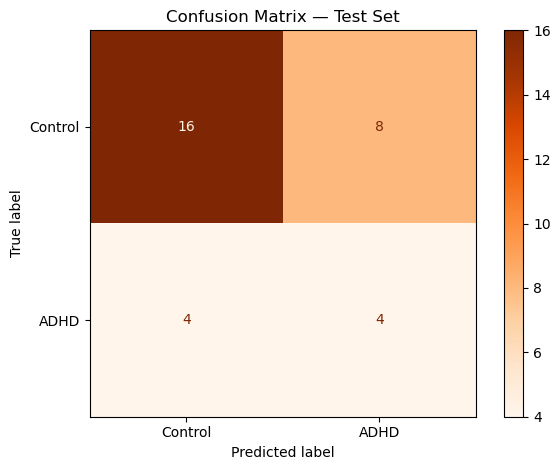

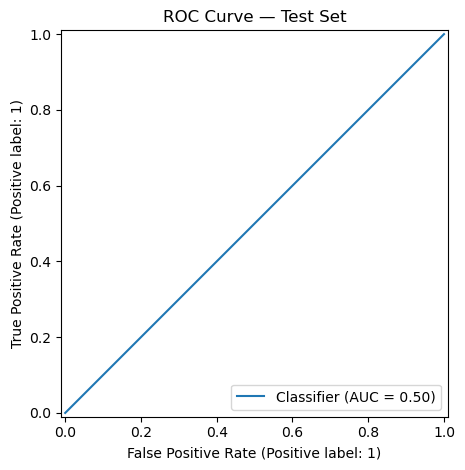

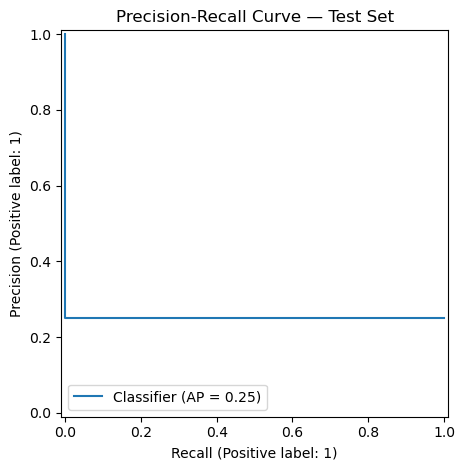

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.pipeline import Pipeline  # <=== Note: from imblearn, not sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold

# === Load and prepare data ===
df = pd.read_csv('Combined_4Condition_Cleaned.csv')
target_col = 'Label'
X = df.drop(columns=['Subject_ID', target_col])
y = df[target_col]

# === Split before downsampling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Cross-validation ===
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# === Pipeline ===
pipeline = Pipeline([
    
    ('feature_select', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                                       threshold=-np.inf, max_features=16)),
    ('under', RandomUnderSampler(random_state=None)),
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True))
])

# === Param grid for SVC ===
param_grid = {
    'svc__C': np.logspace(-2, 2, 5),
    'svc__gamma': np.logspace(-3, 1, 5),
    'svc__class_weight': [None]
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Evaluate ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()
# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")


# === Test evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# over sampling using imlearn(SMOTE)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
✅ Best Params: {'svc__C': 10.0, 'svc__class_weight': None, 'svc__gamma': 0.1}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


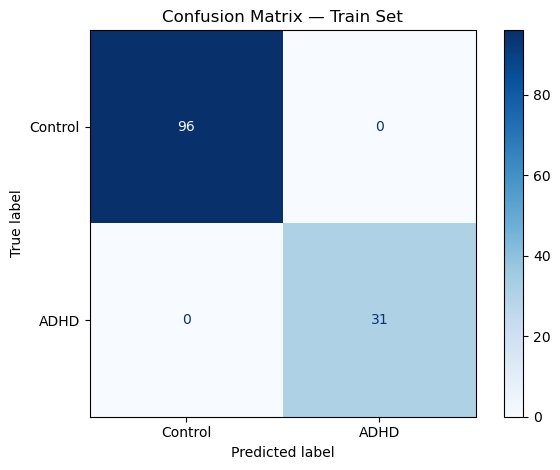

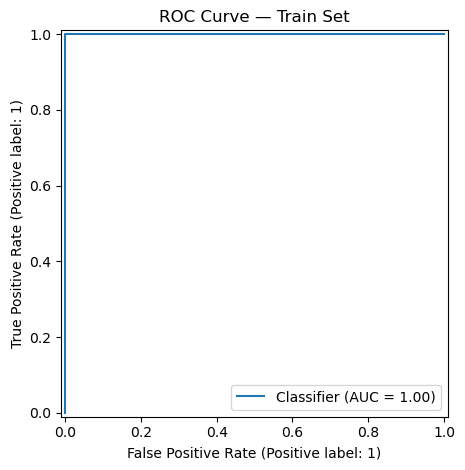

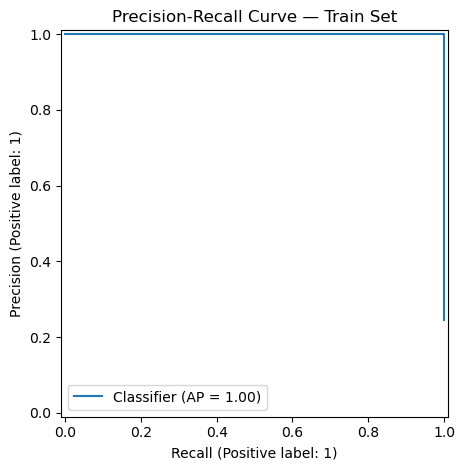

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classificati


📊 Cross-Validated Scores:
fit_time: 0.2250
score_time: 0.0395
test_accuracy: 0.7795
train_accuracy: 1.0000
test_precision: 0.4000
train_precision: 1.0000
test_recall: 0.1917
train_recall: 1.0000
test_f1: 0.2533
train_f1: 1.0000
test_roc_auc: 0.6298
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.74      0.83      0.78        24
        ADHD       0.20      0.12      0.15         8

    accuracy                           0.66        32
   macro avg       0.47      0.48      0.47        32
weighted avg       0.61      0.66      0.63        32

ROC AUC (Test): 0.5833333333333333


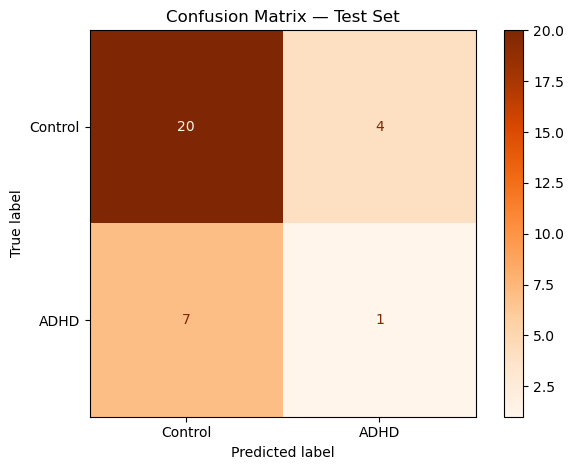

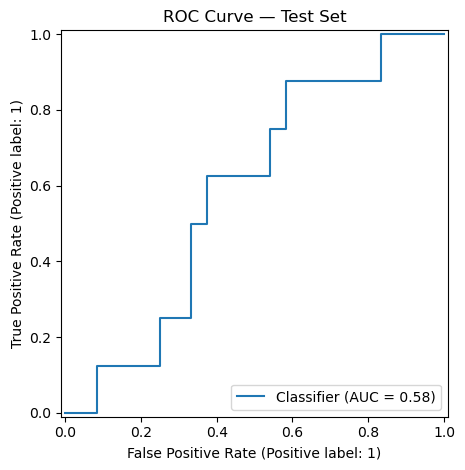

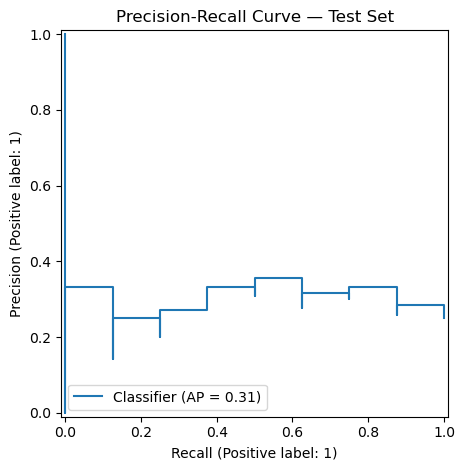

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.pipeline import Pipeline  # <=== Note: from imblearn, not sklearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# === Load and prepare data ===
df = pd.read_csv('Combined_4Condition_Cleaned.csv')
target_col = 'Label'
X = df.drop(columns=['Subject_ID', target_col])
y = df[target_col]

# === Split before downsampling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Cross-validation ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Pipeline ===
pipeline = Pipeline([
    
    ('feature_select', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                                       threshold=-np.inf, max_features=16)),
    ('smote', SMOTE(random_state=42)),                                   
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True))
])

# === Param grid for SVC ===
param_grid = {
    'svc__C': np.logspace(-2, 2, 5),
    'svc__gamma': np.logspace(-3, 1, 5),
    'svc__class_weight': [None, 'balanced']
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Evaluate ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()
# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X_train, y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")


# === Test evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# SMOTEENN

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
✅ Best Params: {'svc__C': 1.0, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.90      0.91      0.90        96
        ADHD       0.70      0.68      0.69        31

    accuracy                           0.85       127
   macro avg       0.80      0.79      0.80       127
weighted avg       0.85      0.85      0.85       127

ROC AUC (Train): 0.9133064516129031


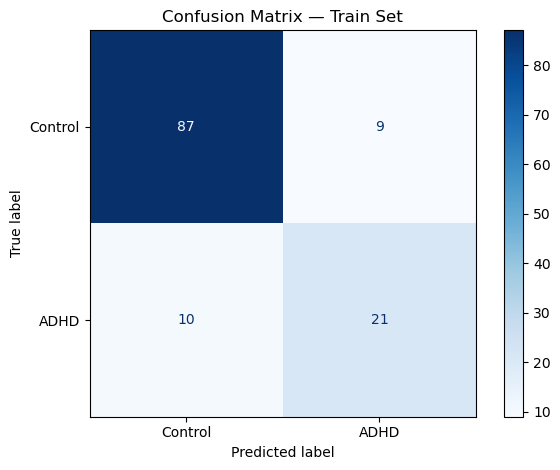

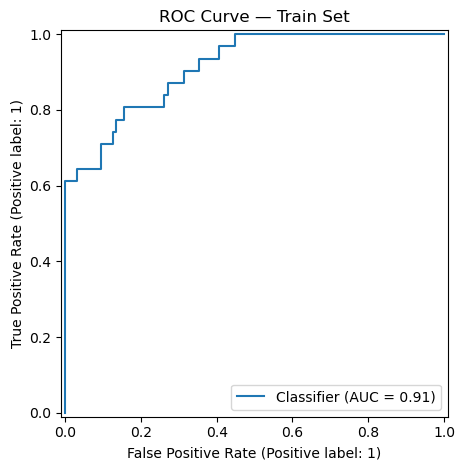

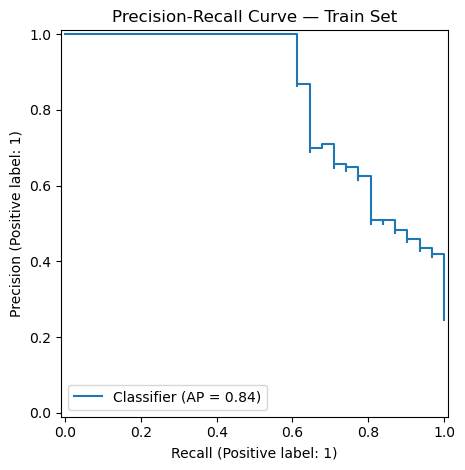

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores (mean across folds):
fit_time: 0.3138
score_time: 0.0496
test_accuracy: 0.6089
train_accuracy: 0.7998
test_precision: 0.2545
train_precision: 0.5713
test_recall: 0.3267
train_recall: 0.8376
test_f1: 0.2729
train_f1: 0.6754
test_roc_auc: 0.5672
train_roc_auc: 0.9239

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.77      0.71      0.74        24
        ADHD       0.30      0.38      0.33         8

    accuracy                           0.62        32
   macro avg       0.54      0.54      0.54        32
weighted avg       0.65      0.62      0.64        32

ROC AUC (Test): 0.5833333333333333


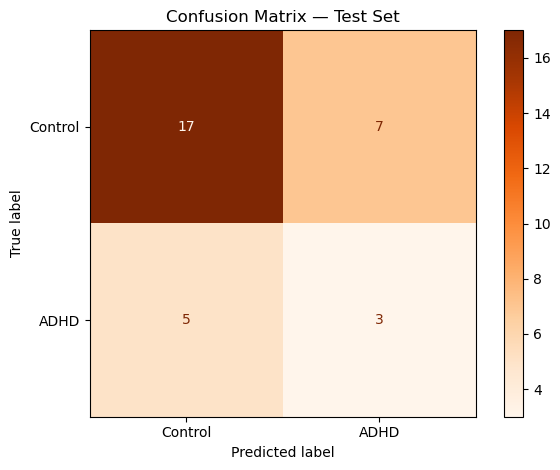

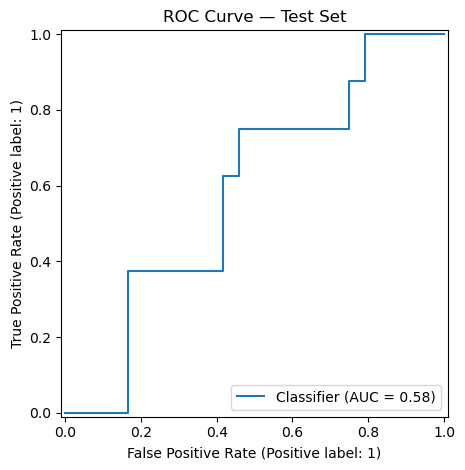

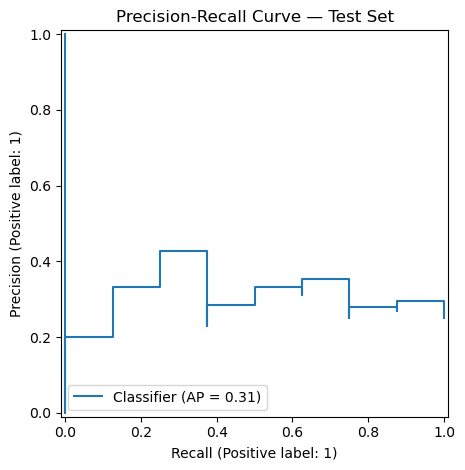

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.pipeline import Pipeline  # from imblearn
from imblearn.combine import SMOTEENN

# === Load and prepare data ===
df = pd.read_csv('Combined_4Condition_Cleaned.csv')
target_col = 'Label'
X = df.drop(columns=['Subject_ID', target_col])
y = df[target_col]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Repeated Stratified K-Fold Cross-validation ===
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

# === Pipeline with SMOTEENN ===
pipeline = Pipeline([
    
    ('feature_select', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                                       threshold=-np.inf, max_features=16)),
    ('smoteenn', SMOTEENN(random_state=42)),                                   
    ('scaler', StandardScaler()),  
    ('svc', SVC(kernel='rbf', probability=True))
])

# === Parameter grid ===
param_grid = {
    'svc__C': np.logspace(-2, 2, 5),
    'svc__gamma': np.logspace(-3, 1, 5),
    'svc__class_weight': [None, 'balanced']
}

# === Grid Search ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train evaluation ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores (mean across folds):")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Test evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# BalancBagging Classifier

Fitting 10 folds for each of 12 candidates, totalling 120 fits
✅ Best Params: {'lr__estimator__C': 1.0, 'lr__estimator__gamma': 'auto'}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.99      0.91      0.95        96
        ADHD       0.77      0.97      0.86        31

    accuracy                           0.92       127
   macro avg       0.88      0.94      0.90       127
weighted avg       0.94      0.92      0.92       127

ROC AUC (Train): 0.9868951612903226


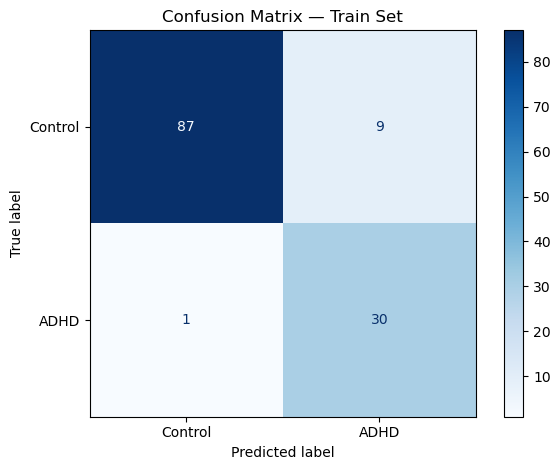

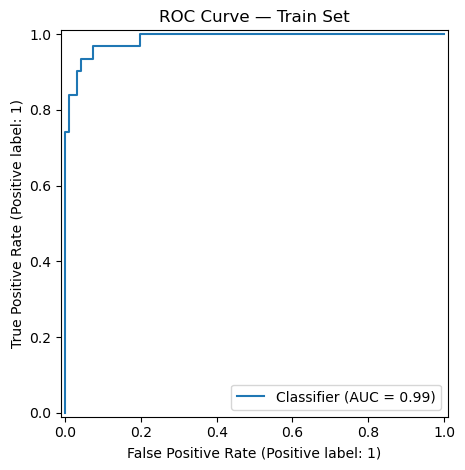

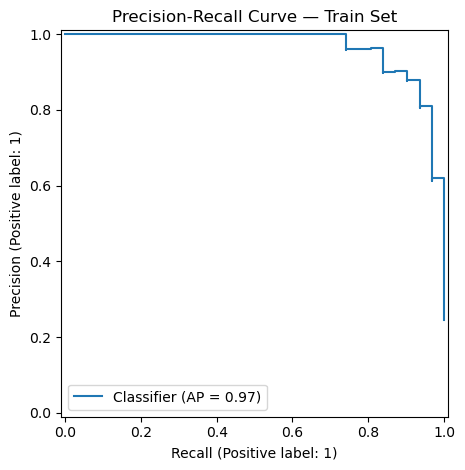


📊 Cross-Validated Scores:
fit_time: 0.4374
score_time: 0.1952
test_accuracy: 0.6921
train_accuracy: 0.8980
test_precision_macro: 0.6125
train_precision_macro: 0.8532
test_recall_macro: 0.6333
train_recall_macro: 0.9026
test_f1_macro: 0.6089
train_f1_macro: 0.8720
test_roc_auc: 0.6722
train_roc_auc: 0.9752

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.80      0.67      0.73        24
        ADHD       0.33      0.50      0.40         8

    accuracy                           0.62        32
   macro avg       0.57      0.58      0.56        32
weighted avg       0.68      0.62      0.65        32

ROC AUC (Test): 0.7135416666666667


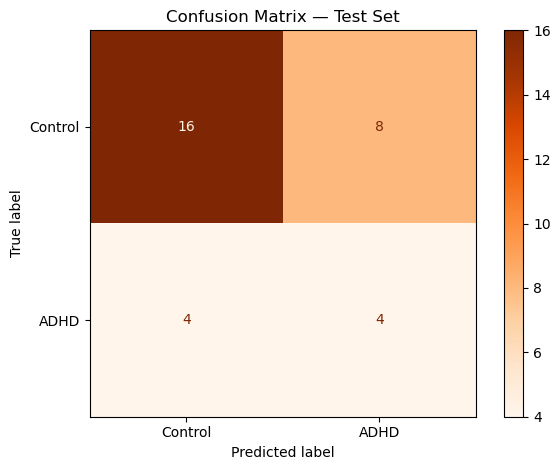

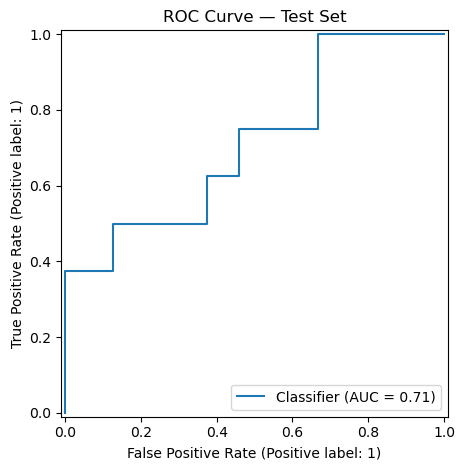

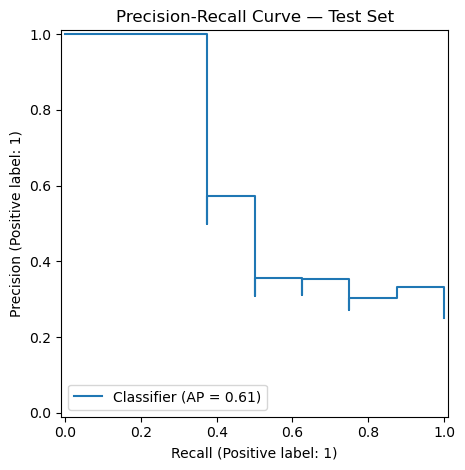

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.ensemble import BalancedBaggingClassifier


from sklearn.model_selection import train_test_split

# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

svc_base_model = SVC(
    kernel='rbf',
    probability=True,  # Needed to use predict_proba
    class_weight=None,  # You can tune this
    random_state=42
)


# ✅ Wrap it in BaggingClassifier
svc_model = BalancedBaggingClassifier(
    estimator=svc_base_model,
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    sampling_strategy='auto',
    replacement=False,
    bootstrap=True
)


# === Pipeline: Raw -> RF selector -> Scaler -> LogisticRegression ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('lr', svc_model)
])

# === Param Grid ===
param_grid = {
    'lr__estimator__C': np.logspace(-3, 2, 6),  # from 0.001 to 100
    'lr__estimator__gamma': ['scale', 'auto']  # or floats like 0.01, 0.1 etc.
}



# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()
